In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import cross_validate,KFold,train_test_split
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import enum
import math
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

In [2]:
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
PATH = '/kaggle/input/autism-prediction/Autism-prediction/'
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
sub = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [4]:
train.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,1,1,1,0,1,1,...,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,f,South Asian,no,no,Australia,no,10.544296,18 and more,?,0
2,3,1,1,1,1,1,1,0,0,1,...,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self,1
3,4,0,0,0,1,0,0,0,0,0,...,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,?,0
4,5,0,0,0,0,1,0,0,0,1,...,m,Black,no,yes,Italy,no,7.949723,18 and more,Self,0


In [5]:
test.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,0,0,0,0,0,0,0,1,0,...,13.445319,m,Asian,no,no,United Arab Emirates,no,-0.914467,18 and more,?
1,2,1,0,0,0,1,0,0,0,0,...,25.057229,f,?,yes,no,New Zealand,no,4.553447,18 and more,Parent
2,3,1,0,0,1,0,1,0,1,0,...,28.799885,f,Asian,no,no,Austria,no,-1.581115,18 and more,Self
3,4,1,1,1,0,1,0,1,0,1,...,16.501526,f,Middle Eastern,yes,no,Bahamas,no,11.779210,18 and more,Relative
4,5,1,0,0,1,1,0,0,1,1,...,54.223869,f,White-European,no,no,Australia,no,10.717321,18 and more,Self


In [6]:
sub.head()

,ID,Class/ASD
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [7]:
train.shape

(800, 22)

In [8]:
test.shape

(200, 21)

In [9]:
train['Class/ASD'].value_counts()

0    615
1    185
Name: Class/ASD, dtype: int64

In [10]:
train.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.0000,800.000000,800.00000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.582500,0.28625,0.321250,0.41500,0.457500,0.20875,0.273750,0.717500,0.316250,0.460000,28.612306,7.058530,0.231250
std,231.0844,0.493455,0.45229,0.467249,0.49303,0.498502,0.40667,0.446161,0.450497,0.465303,0.498709,12.872373,3.788969,0.421896
min,1.0000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,9.560505,-2.594654,0.000000
25%,200.7500,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,19.282082,4.527556,0.000000
50%,400.5000,1.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,25.479960,6.893472,0.000000
75%,600.2500,1.000000,1.00000,1.000000,1.00000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,33.154755,9.892981,0.000000
max,800.0000,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,72.402488,13.390868,1.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [12]:
train.isna().sum()

ID                 0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64

In [13]:
cat_cols = list(train.select_dtypes('object').columns.values)

In [14]:
df = pd.concat([train, test], axis=0)

In [15]:
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])

In [16]:
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [17]:
columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ]

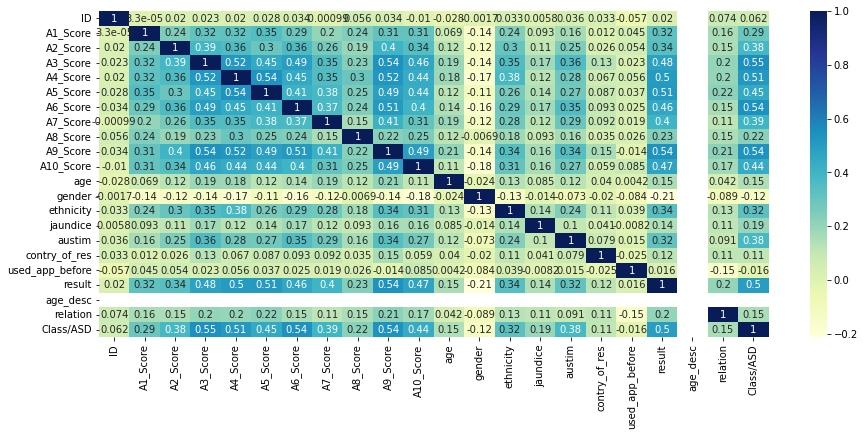

In [18]:
plt.rcParams["figure.figsize"] = (15,6)
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [19]:
xgb_params=  {'learning_rate': 0.002,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'max_depth': 10,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'colsample_bytree': 0.705851334291963,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
}

In [20]:
class Config(enum.Enum):
    SEED = 42
    N_FOLDS = 5
    EARLY_STOP = 300

In [21]:
%%time

random_seed(Config.SEED.value)

auc_score = []

targets = train['Class/ASD'].values

kf = StratifiedKFold(n_splits = Config.N_FOLDS.value, shuffle=True, random_state=Config.SEED.value)    
        
oof = np.zeros((train.shape[0],))
test_preds = 0

for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(X=train, y=targets))):
        df_train, df_val = train.iloc[train_idx][columns], train.iloc[val_idx][columns]
        train_target, val_target = targets[train_idx], targets[val_idx]
        
        train_df = xgb.DMatrix(df_train, label=train_target)
        val_df = xgb.DMatrix(df_val, label=val_target)
        test_df = xgb.DMatrix(test[columns])
        watchlist  = [ (train_df,'train'),(val_df,'eval')]
        model =  xgb.train(
            xgb_params,
            train_df, 
            10000, 
            watchlist, 
            early_stopping_rounds=Config.EARLY_STOP.value,
            verbose_eval=1000
        )
        
        oof_tmp = model.predict(val_df)
        test_tmp = model.predict(test_df)
        oof[val_idx] = oof_tmp
        test_preds += test_tmp/Config.N_FOLDS.value
        auc = roc_auc_score(val_target, oof_tmp)
        auc_score.append(auc)
        print(f'FOLD: {f} AUC: {auc} Mean AUC: {np.mean(auc_score)}')


0it [00:00, ?it/s]

[0]	train-auc:0.86253	eval-auc:0.82103
[355]	train-auc:0.91954	eval-auc:0.89156


1it [00:02,  2.33s/it]

FOLD: 0 AUC: 0.8913425620742694 Mean AUC: 0.8913425620742694
[0]	train-auc:0.85999	eval-auc:0.83388
[933]	train-auc:0.91974	eval-auc:0.92859


2it [00:08,  4.53s/it]

FOLD: 1 AUC: 0.9285871237090749 Mean AUC: 0.9099648428916722
[0]	train-auc:0.86344	eval-auc:0.86256
[1000]	train-auc:0.92428	eval-auc:0.92200
[1490]	train-auc:0.92854	eval-auc:0.92112


3it [00:17,  6.81s/it]

FOLD: 2 AUC: 0.9211162381894091 Mean AUC: 0.9136819746575845
[0]	train-auc:0.81717	eval-auc:0.73401
[1000]	train-auc:0.93165	eval-auc:0.88442
[1807]	train-auc:0.93620	eval-auc:0.88882


4it [00:30,  9.12s/it]

FOLD: 3 AUC: 0.8888156449132059 Mean AUC: 0.9074653922214899
[0]	train-auc:0.83953	eval-auc:0.79334
[315]	train-auc:0.91669	eval-auc:0.89760


5it [00:32,  6.51s/it]

FOLD: 4 AUC: 0.8976049219951658 Mean AUC: 0.9054932981762251
CPU times: user 2min 5s, sys: 359 ms, total: 2min 5s
Wall time: 32.5 s


In [22]:
%%time
shap_preds = model.predict(test_df, pred_contribs=True)

CPU times: user 65.4 ms, sys: 1.09 ms, total: 66.5 ms
Wall time: 20.1 ms


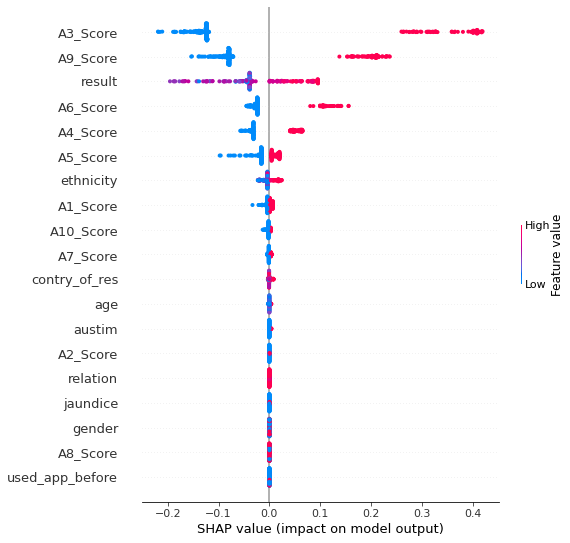

In [23]:
shap.summary_plot(shap_preds[:, :-1], test[columns])

In [24]:
sub['Class/ASD'] = test_preds
sub.to_csv('submission.csv', index=False)

In [25]:
sub.head()

,ID,Class/ASD
0,1,0.177191
1,2,0.179333
2,3,0.267437
3,4,0.465522
4,5,0.324171


In [26]:
cat_cols = list(train.select_dtypes('object').columns.values)
print(cat_cols)
df = pd.concat([train, test], axis=0)
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]
train.info()

[]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    int64  
 13  ethnicity        800 non-null    int64  
 14  jaundice         800 non-null    int64  
 15  austim           800 non-null    int64  
 16  contry_of_res    800 non-null    int64  
 17  used_app_befo

In [27]:
#Define feature columns
feature_columns = {x for x in train.columns}.difference({'ID','age_desc','Class/ASD'})
target = 'Class/ASD'

In [28]:
def get_model(weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu' ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=tfa.losses.TripletSemiHardLoss(), metrics=[])
    if weights is not None:
        model.load_weights(weights)
        
    return model

def get_split(fold, with_csv=False):
    train_idx, val_idx = fold
    
    _csv_train = train.iloc[train_idx]
    _csv_val = train.iloc[val_idx]

    model = get_model()
    x = _csv_train[feature_columns].to_numpy()
    y = _csv_train[target]
    
    x_val = _csv_val[feature_columns].to_numpy()
    y_val = _csv_val[target]
    
    x, y, x_val, y_val
    
    if with_csv:
        return x, y, x_val, y_val, _csv_train, _csv_val
    
    return x, y, x_val, y_val
    

In [29]:
folds = list(KFold().split(train))
fold_i = 0
print(f'Fold #{fold_i}')
model = get_model()
x, y, x_val, y_val, csv_train, csv_val = get_split(folds[fold_i], with_csv=True)
assert not any(csv_val.ID.isin(csv_train.ID))
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 0.99
        self.model.optimizer.lr.assign(new_lr)

save_cb = tf.keras.callbacks.ModelCheckpoint(f'./best_val_new_{fold_i}', save_best_only=True, monitor='val_loss', save_weights_only=True)
h = model.fit(x, y, validation_data=(x_val, y_val), epochs=100, batch_size=64, verbose=2, callbacks=[save_cb, LearningRateReducerCb()])

del model
model = get_model(f'./best_val_new_{fold_i}')

train_emb = model.predict(x)
val_emb = model.predict(x_val)

xgb_params=  {
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'boosting_type' :	 'gbdt',
              'lambda_l1' :	 1.4679791331431786,
              'lambda_l2' :	 0.008403131421304244,
              'colsample_bytree' :	 1.0,
              'bagging_fraction' :	 0.6,
              'feature_fraction' :	 0.6,
              'learning_rate' :	 0.0015584305322779072,
              'max_depth' :	 7,
              'num_leaves' :88,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
              'min_child_samples':	 56
}

xgb =  xgb.XGBClassifier(**xgb_params,n_estimators=10000,random_state=1)
xgb.fit(train_emb, y)

train_acc, val_acc = xgb.score(train_emb, y), xgb.score(val_emb, y_val)

print('#################################################################')
print(f'Train acc: {train_acc} Validation acc: {val_acc}')
print('#################################################################')


test_emb = model.predict(test[feature_columns])
test_pred = xgb.predict(test_emb)
test_probas = xgb.predict_proba(test_emb)

Fold #0
Epoch 1/100
10/10 - 4s - loss: 0.9201 - val_loss: 0.9922
Epoch 2/100
10/10 - 0s - loss: 0.8161 - val_loss: 1.0079
Epoch 3/100
10/10 - 0s - loss: 0.7435 - val_loss: 1.0085
Epoch 4/100
10/10 - 0s - loss: 0.6585 - val_loss: 0.9738
Epoch 5/100
10/10 - 0s - loss: 0.6433 - val_loss: 0.9173
Epoch 6/100
10/10 - 0s - loss: 0.5772 - val_loss: 0.8722
Epoch 7/100
10/10 - 0s - loss: 0.6080 - val_loss: 0.8374
Epoch 8/100
10/10 - 0s - loss: 0.5261 - val_loss: 0.8294
Epoch 9/100
10/10 - 0s - loss: 0.5232 - val_loss: 0.8187
Epoch 10/100
10/10 - 0s - loss: 0.4841 - val_loss: 0.8153
Epoch 11/100
10/10 - 0s - loss: 0.5106 - val_loss: 0.8309
Epoch 12/100
10/10 - 0s - loss: 0.4399 - val_loss: 0.8162
Epoch 13/100
10/10 - 0s - loss: 0.4489 - val_loss: 0.8138
Epoch 14/100
10/10 - 0s - loss: 0.4202 - val_loss: 0.8297
Epoch 15/100
10/10 - 0s - loss: 0.4442 - val_loss: 0.8396
Epoch 16/100
10/10 - 0s - loss: 0.4167 - val_loss: 0.8310
Epoch 17/100
10/10 - 0s - loss: 0.3952 - val_loss: 0.8210
Epoch 18/100
10

In [30]:
val = xgb.predict(val_emb)
#Roc_Auc_Score
print('ROC_AUC_XGB_SCORE:')
roc1= metrics.roc_auc_score(val,y_val)
print(f"roc_Xgb:{roc1}")
print('-'*100)
print()

print('REPORT')
# metrics
report = metrics.classification_report(val,y_val)
print(report)
print('-'*100)
print()

ROC_AUC_XGB_SCORE:
roc_Xgb:0.7966991747936985
----------------------------------------------------------------------------------------------------

REPORT
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       129
         1.0       0.59      0.71      0.65        31

    accuracy                           0.85       160
   macro avg       0.76      0.80      0.78       160
weighted avg       0.86      0.85      0.85       160

----------------------------------------------------------------------------------------------------



In [31]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(val,y_val)

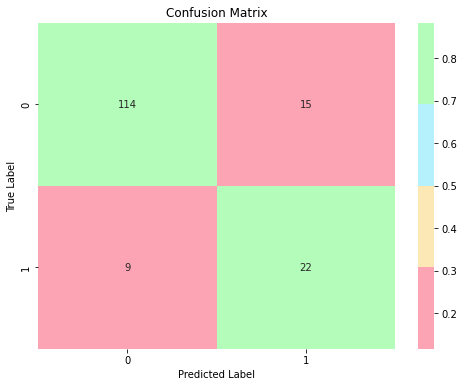

In [32]:
# Define custom color palette
colors = ["#fca3b4", "#fce8b4", "#b4f1fc", "#b4fcb9"]

# Normalize the confusion matrix
confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the confusion matrix as a heatmap with custom colors
sns.heatmap(confusion_normalized, annot=confusion, fmt='d', cmap=sns.color_palette(colors))

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

Text(114.0, 0.5, 'Actual Values')

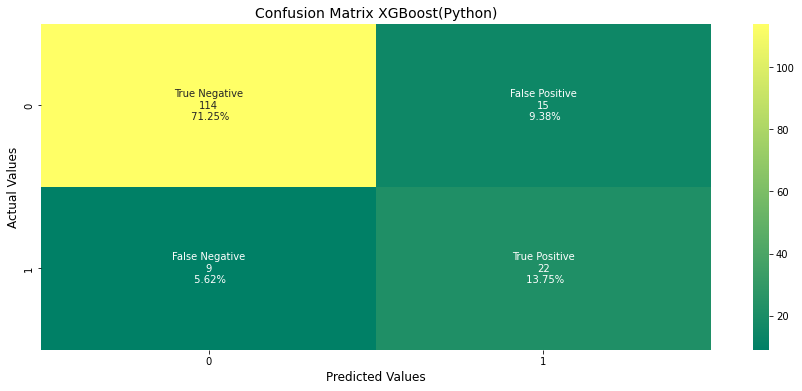

In [63]:
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = [" {0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Add title and axis labels

ax=sns.heatmap(confusion, annot=labels, fmt='', cmap='summer')
plt.title('Confusion Matrix XGBoost(Python)', fontsize = 14) # title with fontsize 20
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12) # y-axis label with fontsize 15

Text(114.0, 0.5, 'Actual Values')

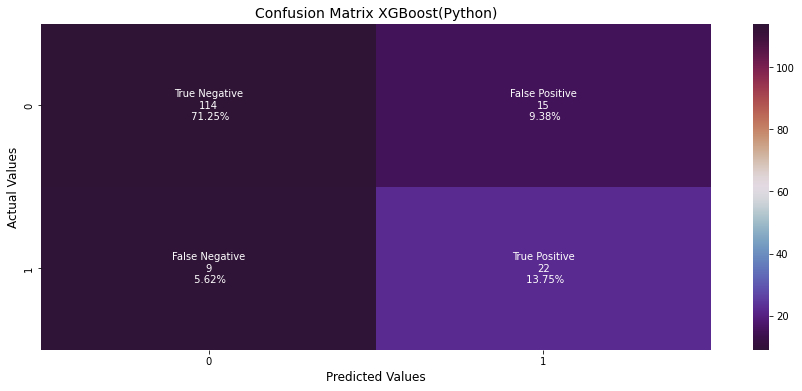

In [62]:
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = [" {0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='twilight_shifted')
plt.title('Confusion Matrix XGBoost(Python)', fontsize = 14) # title with fontsize 20
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12) # y-axis label with fontsize 15